In [11]:
import os
import joblib
import pickle 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from joblib import parallel

from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

In [12]:
# progress bar wrapper for joblib
class TqdmJoblib:
    def __init__(self, tqdm_object):
        self.tqdm = tqdm_object

    def __enter__(self):
        self.original_callback = joblib.parallel.BatchCompletionCallBack

        def new_callback(*args, **kwargs):
            self.tqdm.update()
            return self.original_callback(*args, **kwargs)

        joblib.parallel.BatchCompletionCallBack = new_callback

    def __exit__(self, exc_type, exc_val, exc_tb):
        joblib.parallel.BatchCompletionCallBack = self.original_callback

In [2]:
def plot_distribution(df, column_name, output_file):
    plt.figure(figsize=(8, 5))
    plot = sns.countplot(
        data=df, 
        x=column_name, 
        order=df[column_name].value_counts().index, 
        palette='viridis')
    plt.title(f'Distribution of {column_name} labels')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Annotate counts on the bars
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
    
    plt.tight_layout()
    plt.savefig(output_file)

In [4]:
def plot_correlation(predictors, output_file):
    plt.figure(figsize=(12, 10))
    corr = predictors.corr()
    sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5})
    plt.title('Correlation matrix of predictors')
    plt.tight_layout()
    plt.savefig(output_file)

In [17]:
def split_and_save(X, y_encoded, test_size, output_folder, y_colname, stratify=False):
    
    if stratify:
        strat = y_encoded
    else:
        strat = None

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y_encoded, 
        test_size=test_size, 
        random_state=42, 
        stratify=strat
    )

    # dump
    #joblib.dump(X_train, os.path.join(output_folder, f"X_train_{y_colname}.pkl"))
    joblib.dump(X_test, os.path.join(output_folder, f"X_test_{y_colname}.pkl"))
    #joblib.dump(y_train, os.path.join(output_folder, f"y_train_{y_colname}.pkl"))
    joblib.dump(y_test, os.path.join(output_folder, f"y_test_{y_colname}.pkl"))
    
    return X_train, X_test, y_train, y_test

In [35]:
def run_eval_model(model, model_name, X_train, X_test, y_train, y_test, param_grid, cv, scoring, n_jobs, classes, models_folder, y_colname):

    # prep for progress bar
    n_total = len(ParameterGrid(param_grid)) * cv

    grid = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
    )

    # run gridsearch
    with tqdm(total=n_total, desc="GridSearchCV Progress") as progress_bar:
        with TqdmJoblib(progress_bar):
            grid.fit(X_train, y_train)

    # classification report
    best_params = grid.best_params_
    classification_rep = classification_report(
        y_test, 
        grid.predict(X_test), 
        target_names=classes, 
        output_dict=True)
    
    # save model
    joblib.dump(grid.best_estimator_, os.path.join(models_folder, f"{model_name}_{y_colname}.pkl"))

    return best_params, classification_rep

In [42]:
def main():
    dfs = os.path.join("..", "obj", "data")
    plots = os.path.join("..", "obj", "plots")
    model_extras = os.path.join("..", "obj", "model_extras")
    models = os.path.join("..", "obj", "models")
    textfiles = os.path.join("..", "obj", "text_files")

    data_path = os.path.join(dfs, "NEe_final.pkl")
    with open(data_path, "rb") as f:
        df = pickle.load(f)

    # PLOT CORRELATION BETWEEN PREDICTORS
    X = df.iloc[:, 1:51]
    corr_path = os.path.join(plots, "topic_corr.png")
    plot_correlation(X, corr_path)

    # DEFINE PARAMS
    # logistic regression
    param_grid_lr = {
        'C': [0.01, 0.1, 1, 10],
        #'penalty': ['l2'],
        #'solver': ['lbfgs', 'saga'],
        #'multi_class': ['multinomial'],
        #'class_weight': ['balanced']
    }
    # random forest
    param_grid_rf = {
        'n_estimators': [50, 100, 200, 500],
        #'max_depth': [5, 10, 20, 50],
        #'min_samples_split': [5, 10, 20],
        #'class_weight': ['balanced'],
        #'max_features': [0.6, 0.8, 1],
    }
    # xgboost
    param_grid_xgb = {
        'n_estimators': [50, 100, 200, 500],
        #'max_depth' : [5, 10, 20, 50],
        #'colsample_bytree': [0.6, 0.8, 1],
        #'learning_rate': [2e-3, 2e-2, 2e-1],
        #'subsample': [0.6, 0.8, 1.0]
    }

    # DEFINE MODELS
    # logistic regression
    model_lr = LogisticRegression(
        max_iter=1000)
    # random forest
    model_rf = RandomForestClassifier(
        random_state=42)
    # xgboost
    model_xgb = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42)

    # RUN FOR AU AND FANDOM
    for target in ["AU", "Fandom"]:

        # get class distribution
        distr_path = os.path.join(plots, f"{target}_distr.png")
        plot_distribution(df, target, distr_path)

        # select y
        y = df[target]

        # encode class labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        class_labels = label_encoder.classes_
        joblib.dump(class_labels, os.path.join(model_extras, f"class_labels_{target}.pkl"))
    
        # split data and save for future analysis
        X_train, X_test, y_train, y_test = split_and_save(X, y_encoded, 0.2, model_extras, target, stratify=True)

        # dummy classifier to set baseline
        dummy_clf = DummyClassifier(strategy="most_frequent")
        dummy_clf.fit(X_train, y_train)
        d_cr = classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)

        # run logistic regression
        lr_best, lr_cr = run_eval_model(
            model_lr, "lr", 
            X_train, X_test, y_train, y_test, 
            param_grid_lr, 
            5, 'f1_macro', -1, 
            class_labels, models, target)

        # run random forest
        rf_best, rf_cr = run_eval_model(
            model_rf, "rf", 
            X_train, X_test, y_train, y_test, 
            param_grid_rf, 
            5, 'f1_macro', -1, 
            class_labels, models, target)

        # run xgboost
        xgb_best, xgb_cr = run_eval_model(
            model_xgb, "xgb", 
            X_train, X_test, y_train, y_test, 
            param_grid_xgb, 
            5, 'f1_macro', -1, 
            class_labels, models, target)
        
        with open(os.path.join(textfiles, f"test_{target}.txt"), 'w') as f:
            # Write the classification report dictionary to the file
            f.write(f"LR best params: {lr_best}\n")
            f.write(str(lr_cr) + "\n")
            f.write("\n")
            f.write(f"RF best params: {rf_best}\n")
            f.write(str(rf_cr) + "\n")
            f.write("\n")
            f.write(f"XGB best params: {xgb_best}\n")
            f.write(str(xgb_cr) + "\n")

/tmp/ipykernel_1888/2825404099.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetri

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_1888/2825404099.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetri

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

GridSearchCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

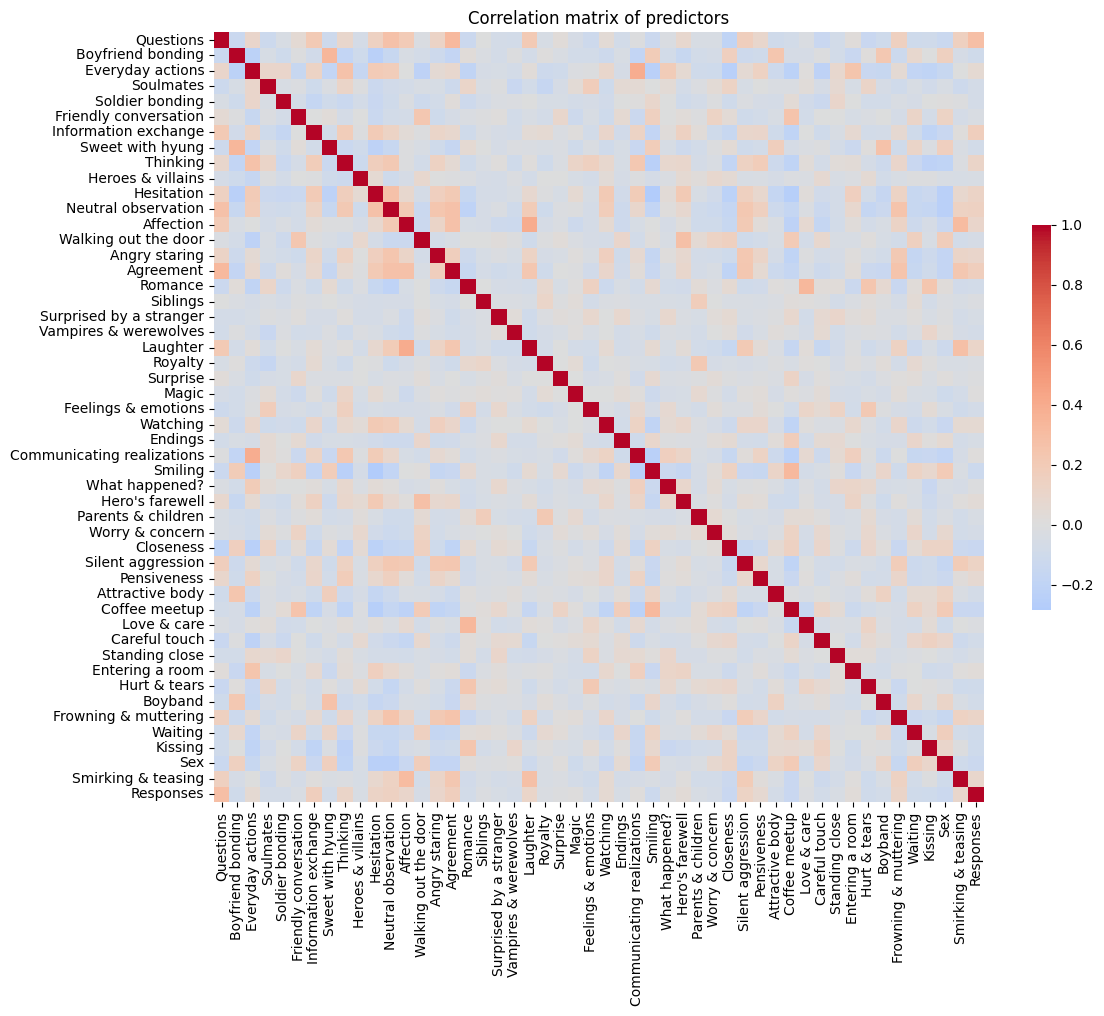

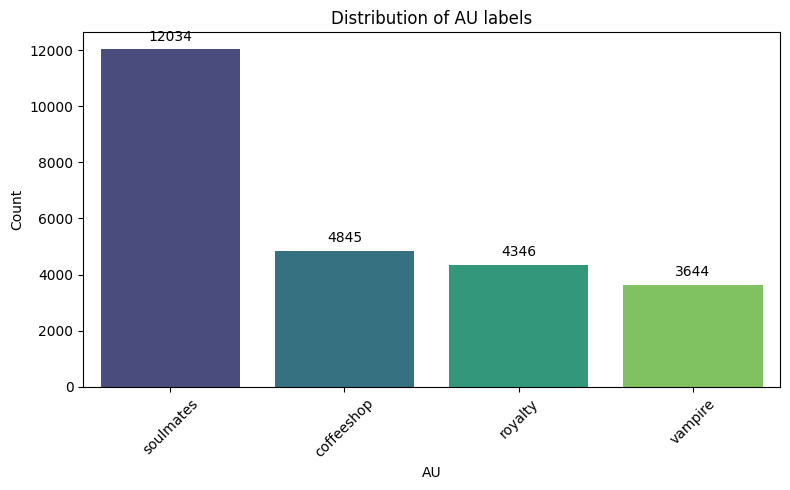

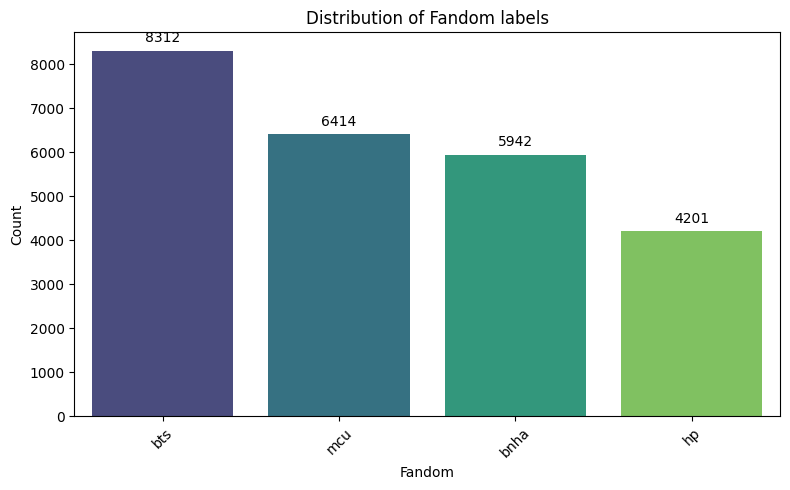

In [43]:
main()